HMM-DDM: Mouse Data
========================
In this notebook we will analyse a dataset of mice performing a two-alternative forced choice (TAFC) task developed in Kane, Senne, and Scott, 2025. mice performed this task daily in two-hour periods.

In [1]:
using HiddenMarkovModels
using DriftDiffusionModels
using Plots
using CSV
using DataFrames
using Dates
using Random
using Distributions
using LinearAlgebra
using StatsBase
using JLD2
using Printf

## Load and Preprocess the data

In [3]:
ddir = "../data/mouse_df.csv"
# load in the data
df = CSV.File(ddir) |> DataFrame;

In [4]:
# Group by animal name and count trials
trial_counts = combine(groupby(df, :name), nrow => :trial_count)

# Sort by count in descending order
sort!(trial_counts, :trial_count, rev=true)

# pick a mouse of interest (start with mouse of most trials)
moi = trial_counts[1, :name]

# get the data for the mouse of interest
mouse_df = df[df.name .== moi, :]

# Filter out trials with "omission" outcome
valid_trials = findall(outcome -> outcome != "omission", mouse_df.outcome)
filtered_df = mouse_df[valid_trials, :]

# Map correct -> 1 and incorrect -> -1 (only for error and correct, omissions are gone)
numeric_outcomes = [outcome == "correct" ? 1 : -1 for outcome in filtered_df.outcome]

# Get reaction times, filter out "NAN" values
valid_rt_indices = findall(rt -> uppercase(string(rt)) != "NAN", filtered_df.rt)
# valid_trials = findall(rt -> rt > 0.2, filtered_df.rt)

# Apply both filters to keep data aligned
final_df = filtered_df[valid_rt_indices, :]
final_outcomes = numeric_outcomes[valid_rt_indices]

# Convert RTs to Float64
# final_rts = [parse(Float64, rt) for rt in final_df.rt]
final_rts = final_df.rt
final_stimulus = final_df.correct_side
final_stimulus = [stim == "right" ? 1 : -1 for stim in final_stimulus]

# Extract just the date part from the timestamp strings
dates = [Date(split(dt)[1]) for dt in final_df.trial_datetime]

# Get unique dates in chronological order
unique_dates = sort(unique(dates))

# Create a vector of vectors, where each inner vector contains DDMResults for one day
results_by_date = Vector{Vector{DDMResult}}()

for date in unique_dates
    # Get indices for this date
    day_indices = findall(dates .== date)
    
    # Skip days with no valid data
    if isempty(day_indices)
        continue
    end
    
    # Extract RTs and outcomes for this date
    day_rts = final_rts[day_indices]
    day_outcomes = final_outcomes[day_indices]
    day_stim_side = final_stimulus[day_indices]
    
    # Create DDMResult objects for this day
    day_results = [DDMResult(rt, choice, stim) for (rt, choice, stim) in zip(day_rts, day_outcomes, day_stim_side)]

    # Add to our vector of vectors
    push!(results_by_date, day_results)
end

# Now calculate the sequence ends (cumulative sum of lengths)
seq_ends = cumsum([length(seq) for seq in results_by_date])

# Concatenate all results into a single vector
all_results = reduce(vcat, results_by_date)



12311-element Vector{DDMResult}:
 DDMResult(0.2716, 1, -1)
 DDMResult(0.4124, -1, 1)
 DDMResult(0.2669, 1, -1)
 DDMResult(0.8428, 1, 1)
 DDMResult(0.3541, 1, 1)
 DDMResult(0.247, 1, -1)
 DDMResult(0.4099, 1, -1)
 DDMResult(0.2372, -1, -1)
 DDMResult(0.3275, -1, 1)
 DDMResult(0.2344, 1, 1)
 ⋮
 DDMResult(0.4864, 1, 1)
 DDMResult(0.2847, -1, -1)
 DDMResult(0.2424, 1, 1)
 DDMResult(0.4899, -1, -1)
 DDMResult(0.226, -1, -1)
 DDMResult(0.2562, -1, -1)
 DDMResult(0.5747, 1, -1)
 DDMResult(0.3208, 1, 1)
 DDMResult(0.4196, 1, -1)

In [10]:
df = DataFrame(rt = final_rts, outcome = numeric_outcomes)
CSV.write("rts_outcomes.csv", df)

"rts_outcomes.csv"

In [12]:
count_ones = sum(numeric_outcomes .== 1) / length(numeric_outcomes)

0.6612785313946877

In [29]:
CSV.write("final_rts.csv", DataFrame(final_rts=final_rts))

"final_rts.csv"

# Visualize the correct and error RT distirbutions

In [30]:
correct_trials = [x for x in all_results if x.choice == 1]
incorrect_trials = [x for x in all_results if x.choice == -1];

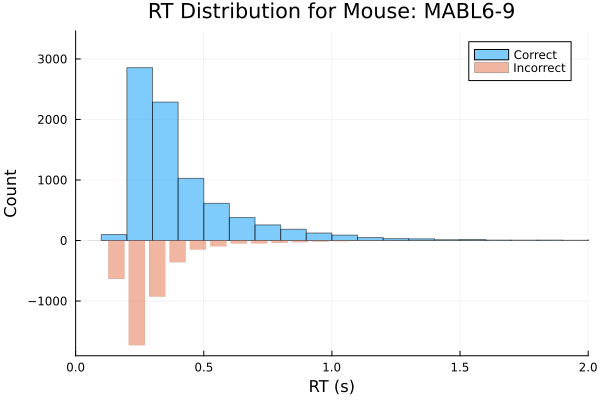

In [5]:
rt_dist_plot = histogram([x.rt for x in correct_trials], bins=100, alpha=0.5, label="Correct", legend=:topright)
incorrect_rts = [x.rt for x in incorrect_trials]
h = fit(Histogram, incorrect_rts, range(0, maximum(incorrect_rts), length=101))
bar!(h.edges[1][1:end-1], -h.weights, width=step(h.edges[1]), 
     alpha=0.5, 
     label="Incorrect")
# Adjust y-axis to make room for the downward bars
xlabel!("RT (s)")
ylabel!("Count")
title!("RT Distribution for Mouse: $moi")
ylims!(minimum([-h.weights; 0]) * 1.1, maximum(h.weights) * 2)
xlims!(0, 2)

## Two State Model

In [17]:
# generate a HMM to start from
trans_guess = [0.95 0.025 0.025; 0.025 0.95 0.025; 0.025 0.025 0.95]
init_guess = [1/3, 1/3, 1/3]

ddm_1_guess = DriftDiffusionModel(0.5, 0.5, 0.5, 0.05)
ddm_2_guess = DriftDiffusionModel(1.0, 0.5, 0.5, 0.05)
ddm_3_guess = DriftDiffusionModel(1.5, 0.5, 0.5, 0.05)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
dists_guess = [ddm_1_guess, ddm_2_guess, ddm_3_guess]

# create a prior distirbution for the initial states and transition matrix (sticky HMM)
α₀ = ones(3)
αₜ = ones(3, 3) # .* 2
# αₜ[diagind(αₜ)] .= 3

hmm = PriorHMM(init_guess, trans_guess, dists_guess, αₜ, α₀)
hmm_est, lls = baum_welch(hmm, all_results; seq_ends=seq_ends)

(PriorHMM{Float64, DriftDiffusionModel}([0.569088897443331, 8.013657119664128e-90, 0.43091110255666887], [0.945084099130887 7.806264603552896e-5 0.054837838223077466; 0.00022518158410772632 0.715143835524006 0.2846309828918864; 0.0025043686116509073 0.16077296202600305 0.8367226693623461], DriftDiffusionModel[DriftDiffusionModel(0.790863030010281, 2.3507156829418085, 0.5037853010160402, 0.1481798299127339), DriftDiffusionModel(2.0060940701504153, 7.110330278145525, 0.48216540240335587, 0.13937474026708815), DriftDiffusionModel(1.186950060619474, 2.1117908272692062e-32, 0.5473057490482995, 0.15399999999999997)], [1.0 1.0 1.0; 1.0 1.0 1.0; 1.0 1.0 1.0], [1.0, 1.0, 1.0]), [-5944.595304577338, -1508.8288041120306, -852.4701358914645, -632.5693133113771, -574.4535976550656, -508.68882279521904, -436.017145740867, -358.7266979643803, -265.68075314076304, -157.74254561278025  …  294.37442256158397, 294.3747433903124, 294.3750473859834, 294.37533548429957, 294.3756085652736, 294.37586745687526

In [10]:
# one state DDM

trans_guess = [1.0;;]
init_guess = [1.0]
ddm_1_guess = DriftDiffusionModel(0.5, 0.5, 0.5, 0.05)
dists_guess = [ddm_1_guess]

# create a prior distirbution for the initial states and transition matrix (sticky HMM)
α₀ = ones(1)
αₜ = ones(1, 1) # .* 2

hmm = HMM(init_guess, trans_guess, dists_guess)
hmm_est, lls = baum_welch(hmm, all_results; seq_ends=seq_ends)

(Hidden Markov Model with:
 - initialization: [1.0]
 - transition matrix: [1.0;;]
 - observation distributions: [DriftDiffusionModel(1.0591751090949766, 0.5595276075801346, 0.530275061472517, 0.15399999999999997)], [-55273.872464401684, -2157.600259922491, -2157.6002599224917])

In [22]:
states, obs = rand(hmm_est, 10000)

(state_seq = [3, 3, 2, 3, 3, 3, 3, 3, 3, 3  …  2, 3, 3, 3, 3, 2, 2, 2, 2, 2], obs_seq = DDMResult[DDMResult(0.7510800000007604, -1, -1), DDMResult(1.0488570000038988, -1, -1), DDMResult(0.3498499999975578, -1, -1), DDMResult(1.0826550000011184, -1, 1), DDMResult(0.508088999993773, 1, 1), DDMResult(0.6414449999976077, 1, 1), DDMResult(0.2187550000001981, 1, 1), DDMResult(0.4271449999954897, -1, -1), DDMResult(1.0611790000028851, 1, -1), DDMResult(0.25198400000017623, 1, -1)  …  DDMResult(0.2324560000002118, 1, 1), DDMResult(0.4299229999954154, 1, 1), DDMResult(0.2778529999994841, -1, -1), DDMResult(0.2722959999996328, 1, -1), DDMResult(0.3589539999973142, -1, -1), DDMResult(0.2610159999999346, 1, 1), DDMResult(0.22889300000020824, -1, -1), DDMResult(0.24333100000022267, 1, 1), DDMResult(0.2492440000002286, -1, -1), DDMResult(0.23720400000021655, -1, -1)])

In [ ]:
γ, _ = HiddenMarkovModels.forward_backward(hmm_est, all_results; seq_ends=seq_ends)


([0.03544009762783013 0.006702273211903686 … 0.001397007438770333 0.001268142243370555; 1.2496924351061346e-95 3.7269509517920904e-8 … 0.18170757278755503 1.442690955345688e-7; 0.9645599023721719 0.9932976895185887 … 0.8168954197736746 0.998731713487534], [-224.54452697128107, -74.28892110659378, -18.679177156308054, 155.12283237625573, 2.490178275861554, -64.31403096425363, -32.1248796039644, 63.216099670778114, 5.916540457291632, 123.62613028587954  …  -110.55653024661363, -103.92882913548705, -201.741397914798, -108.0273949403144, -230.65066242864418, 127.55374569616112, 71.96633904154896, 157.8186758700369, 372.83516475948903, 453.26795500746425])

In [43]:
K = maximum(ml_states)
n   = zeros(Int, K)
sum_correct = zeros(Float64, K)

for (s, x) in zip(ml_states, xs)
    n[s] += 1
    sum_correct[s] += x          # x can be 0/1 (or Bool)
end

acc = [n[k] == 0 ? NaN : sum_correct[k] / n[k] for k in 1:K]

3-element Vector{Float64}:
 0.5628415300546448
 0.5906666666666667
 0.7124759019553842

In [ ]:
ml_states = [argmax(γ[:, i]) for i in 1:size(γ, 2)]
xs = [ch.choice == 1 ? 1 : 0 for ch in all_results]


12311-element Vector{Int64}:
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3
 ⋮
 3
 2
 2
 3
 2
 2
 3
 3
 3

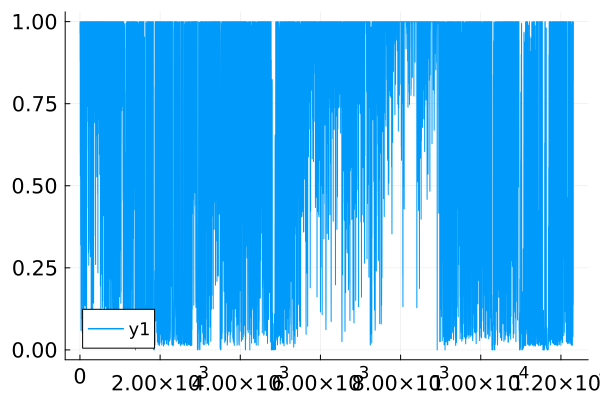

In [72]:
plot(γ'[:, 3])

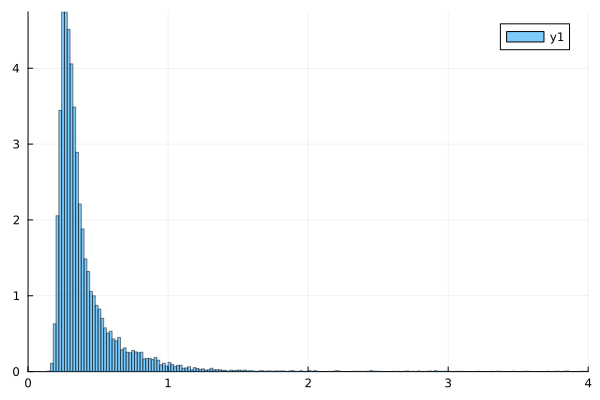

In [23]:
x = [y.rt for y in obs]
histogram([y.rt for y in all_results], normalize=:pdf, alpha=0.5)
xlims!(0, 4)

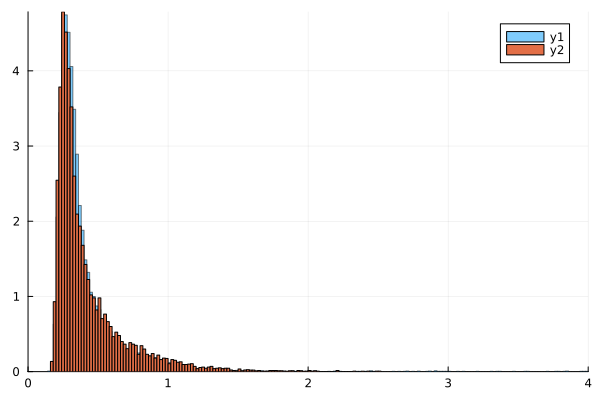

In [24]:
histogram!(x, normalize=:pdf)
xlims!(0, 4)

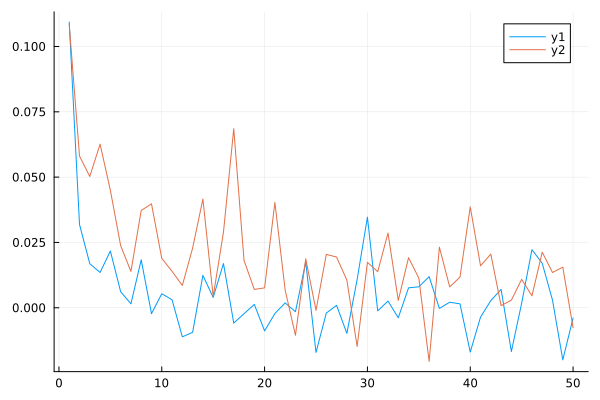

In [25]:
using StatsBase
plot(pacf(x, 1:50))
plot!(pacf([y.rt for y in all_results], 1:50))

In [74]:
using HypothesisTests
ApproximateTwoSampleKSTest(x, [y.rt for y in all_results])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0500137

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-11

Details:
    number of observations:   [10000,12311]
    KS-statistic:              3.7151447270617144


In [12]:
function state_dependent_histograms(true_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                    simulated_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                    n_bins::Int=100)

    default(guidefontsize=16, tickfontsize=14, legendfontsize=12)

    true_results, true_states = true_data
    sim_results, sim_states = simulated_data

    n_states = maximum(vcat(true_states, sim_states))  # assume states ∈ 1:n
    all_rts = [r.rt for r in true_results] ∪ [r.rt for r in sim_results]
    min_rt, max_rt = extrema(all_rts)
    bin_edges = range(min_rt, max_rt, length=n_bins+1)
    bin_width = (max_rt - min_rt) / n_bins
    bin_centers = range(min_rt + bin_width/2, max_rt - bin_width/2, length=n_bins)

    # Utility function
    function compute_hist_heights(data::Vector{Float64})
        if isempty(data)
            return zeros(n_bins)
        end
        hist = fit(Histogram, data, bin_edges)
        normalize(hist.weights ./ bin_width, 1)
    end

    # Build plots for each state
    plots = Vector{Plots.Plot}(undef, n_states)

    for k in 1:n_states
        # Extract trial indices for state k
        true_idx = findall(x -> x == k, true_states)
        sim_idx  = findall(x -> x == k, sim_states)

        true_correct = [r.rt for (i, r) in enumerate(true_results) if i in true_idx && r.choice == 1]
        true_error   = [r.rt for (i, r) in enumerate(true_results) if i in true_idx && r.choice == -1]
        sim_correct  = [r.rt for (i, r) in enumerate(sim_results) if i in sim_idx  && r.choice == 1]
        sim_error    = [r.rt for (i, r) in enumerate(sim_results) if i in sim_idx  && r.choice == -1]

        true_correct_heights = compute_hist_heights(true_correct)
        true_error_heights   = compute_hist_heights(true_error)
        sim_correct_heights  = compute_hist_heights(sim_correct)
        sim_error_heights    = compute_hist_heights(sim_error)

        p = plot(title="State $k Response Times", xlabel="RT (s)", ylabel="Density")

        # Positive: correct
        bar!(p, bin_centers, true_correct_heights,
            label="True (Correct)", alpha=0.8, color=:blue, bar_width=bin_width)
        bar!(p, bin_centers, sim_correct_heights,
            label="Simulated (Correct)", alpha=0.8, color=:lightblue, bar_width=bin_width)

        # Negative: error
        bar!(p, bin_centers, -true_error_heights,
            label="True (Error)", alpha=0.8, color=:red, bar_width=bin_width)
        bar!(p, bin_centers, -sim_error_heights,
            label="Simulated (Error)", alpha=0.8, color=:pink, bar_width=bin_width)

        hline!(p, [0], color=:black, linestyle=:dash, label=nothing)

        # Symmetric ticks
        max_y = maximum(abs.([
            maximum(true_correct_heights), maximum(true_error_heights),
            maximum(sim_correct_heights),  maximum(sim_error_heights)
        ]))
        y_ticks = collect(range(-max_y, max_y, length=7))
        yticks!(p, y_ticks, [@sprintf("%.2f", abs(y)) for y in y_ticks])

        plots[k] = p
    end

    return plot(plots..., layout=(n_states, 1), size=(800, 300 * n_states), legend=:topright)

end

state_dependent_histograms (generic function with 2 methods)

In [13]:
state_dependent_histograms(
    (all_results, most_likely_states),
    (dat_sim, seq_sim),
    100
)

UndefVarError: UndefVarError: `most_likely_states` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [14]:
savefig("state_dependent_histograms.svg")

"c:\\Users\\ryansenne\\Documents\\GitHub\\DriftDiffusionModels.jl\\notebooks\\state_dependent_histograms.svg"

In [15]:
posterior_plot = plot()
plot!(posterior[1, 1:1000], label="State 1", linewidth=2.0)
plot!(posterior[2, 1:1000], label="State 2", linewidth=2.0)
plot!(posterior[3, 1:1000], label="State 3", linewidth=2.0)
ylabel!("Pr(State i)")
xlabel!("Trial")

# savefig(posterior_plot, "posterior.svg")

UndefVarError: UndefVarError: `posterior` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [16]:
one_state_ddm = fit!(DriftDiffusionModel(v=1.1, B=3.3, τ=0.1), all_results)

DriftDiffusionModel(1.0591751090987855, 0.559527607960861, 0.5302750614576346, 0.15399999999999997)

In [17]:
one_state_samples = [rand(one_state_ddm) for _ in 1:10000]
three_state_samples = rand(hmm_est, 10000)

(state_seq = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], obs_seq = DDMResult[DDMResult(0.23688600000021623, 1, -1), DDMResult(0.8029960000022532, -1, 1), DDMResult(0.30076199999887115, -1, 1), DDMResult(0.21089100000019023, 1, -1), DDMResult(0.7907350000019007, 1, -1), DDMResult(0.4489729999949057, 1, -1), DDMResult(0.5057799999937066, -1, 1), DDMResult(0.8349880000031732, -1, -1), DDMResult(0.25509600000009297, -1, -1), DDMResult(0.21461500000019396, 1, -1)  …  DDMResult(0.6903289999990134, -1, -1), DDMResult(0.7177779999998027, -1, -1), DDMResult(0.3440339999977134, 1, -1), DDMResult(0.4230759999955986, -1, 1), DDMResult(0.20141700000018076, -1, 1), DDMResult(0.2808909999994028, -1, -1), DDMResult(0.2547440000001024, -1, 1), DDMResult(0.24463100000022397, -1, 1), DDMResult(0.4465369999949709, 1, -1), DDMResult(0.6220959999970513, -1, 1)])

In [18]:
function ppc_asymmetric_histogram(true_data::Vector{DDMResult},
                                         sim1_data::Vector{DDMResult},
                                         sim_bestfit_data::Vector{DDMResult};
                                         n_bins::Int=100)

    default(guidefontsize=16, tickfontsize=14, legendfontsize=12)

    # Split correct/error
    split_choices(data) = (
        correct = [r.rt for r in data if r.choice == 1],
        error   = [r.rt for r in data if r.choice == -1]
    )

    true_c, true_e     = split_choices(true_data)
    sim1_c, sim1_e     = split_choices(sim1_data)
    bestfit_c, bestfit_e = split_choices(sim_bestfit_data)

    # Define shared bin edges
    all_rts = vcat(true_c, true_e, sim1_c, sim1_e, bestfit_c, bestfit_e)
    min_rt, max_rt = extrema(all_rts)
    bin_edges = range(min_rt, max_rt, length=n_bins+1)
    bin_width = (max_rt - min_rt) / n_bins
    bin_centers = range(min_rt + bin_width/2, max_rt - bin_width/2, length=n_bins)

    function compute_hist_heights(data::Vector{Float64})
        if isempty(data)
            return zeros(n_bins)
        end
        hist = fit(Histogram, data, bin_edges)
        hist.weights ./ (sum(hist.weights) * bin_width)
    end

    # Compute heights
    h = Dict(
        :true_c     => compute_hist_heights(true_c),
        :true_e     => compute_hist_heights(true_e),
        :sim1_c     => compute_hist_heights(sim1_c),
        :sim1_e     => compute_hist_heights(sim1_e),
        :bestfit_c  => compute_hist_heights(bestfit_c),
        :bestfit_e  => compute_hist_heights(bestfit_e),
    )

    # Max for symmetric y-axis
    max_y = maximum(abs.([
        h[:true_c]; h[:true_e];
        h[:sim1_c]; h[:sim1_e];
        h[:bestfit_c]; h[:bestfit_e]
    ]))
    y_ticks = range(-max_y, max_y, length=7)
    tick_labels = [@sprintf("%.2f", abs(y)) for y in y_ticks]

    # LEFT: 1-state vs true
    p1 = plot(title="True vs 1-State DDM", xlabel="RT (s)", ylabel="Density")
    bar!(p1, bin_centers, h[:true_c],     label="True (Correct)", color=:black, alpha=0.6, bar_width=bin_width)
    bar!(p1, bin_centers, h[:sim1_c],     label="1-State (Correct)", color=:orange, alpha=0.6, bar_width=bin_width)
    bar!(p1, bin_centers, -h[:true_e],    label="True (Error)", color=:black, alpha=0.6, bar_width=bin_width)
    bar!(p1, bin_centers, -h[:sim1_e],    label="1-State (Error)", color=:red, alpha=0.6, bar_width=bin_width)
    hline!(p1, [0], color=:black, linestyle=:dash, label=nothing)
    yticks!(p1, y_ticks, tick_labels)
    xlims!(0,4)

    # RIGHT: best-fit vs true
    p2 = plot(title="True vs Best-Fit Model", xlabel="RT (s)", ylabel="Density")
    bar!(p2, bin_centers, h[:true_c],      label="True (Correct)", color=:black, alpha=0.6, bar_width=bin_width)
    bar!(p2, bin_centers, h[:bestfit_c],   label="Best-Fit (Correct)", color=:blue, alpha=0.6, bar_width=bin_width)
    bar!(p2, bin_centers, -h[:true_e],     label="True (Error)", color=:black, alpha=0.6, bar_width=bin_width)
    bar!(p2, bin_centers, -h[:bestfit_e],  label="Best-Fit (Error)", color=:purple, alpha=0.6, bar_width=bin_width)
    hline!(p2, [0], color=:black, linestyle=:dash, label=nothing)
    yticks!(p2, y_ticks, tick_labels)
    xlims!(0,4)

    return plot(p1, p2, layout=(1,2), size=(1000, 400), legend=:topright)
end


ppc_asymmetric_histogram (generic function with 1 method)

In [19]:
ppc = ppc_asymmetric_histogram(all_results,
one_state_samples,
three_state_samples[2])

savefig(ppc, "ppc_asymmetric_histogram.svg")

"c:\\Users\\ryansenne\\Documents\\GitHub\\DriftDiffusionModels.jl\\notebooks\\ppc_asymmetric_histogram.svg"

lls

In [20]:
using StatsBase

function ks_comparison_plot(true_data::Vector{DDMResult},
                            sim1_data::Vector{DDMResult},
                            sim_bestfit_data::Vector{DDMResult})

    default(guidefontsize=16, tickfontsize=14, legendfontsize=12)

    # Extract sorted RTs for correct and error trials
    function split_sorted_rts(data)
        correct = sort([r.rt for r in data if r.choice == 1])
        error   = sort([r.rt for r in data if r.choice == -1])
        return correct, error
    end

    tc, te = split_sorted_rts(true_data)
    s1c, s1e = split_sorted_rts(sim1_data)
    bfc, bfe = split_sorted_rts(sim_bestfit_data)

    # Compute ECDF values
    function ecdf_xy(data)
        ec = ecdf(data)
        x = sort(data)
        y = ec.(x)
        return x, y
    end

    # === Correct Trials ===
    tc_x, tc_y = ecdf_xy(tc)
    s1c_x, s1c_y = ecdf_xy(s1c)
    bfc_x, bfc_y = ecdf_xy(bfc)

    p1 = plot(title="KS Plot – Correct Trials",
              xlabel="RT (s)", ylabel="ECDF", legend=:bottomright)

    plot!(p1, tc_x, tc_y, label="True", lw=2, color=:black)
    plot!(p1, s1c_x, s1c_y, label="1-State", lw=2, color=:gray)
    plot!(p1, bfc_x, bfc_y, label="3-State", lw=2, color=:blue)

    # === Error Trials ===
    te_x, te_y = ecdf_xy(te)
    s1e_x, s1e_y = ecdf_xy(s1e)
    bfe_x, bfe_y = ecdf_xy(bfe)

    p2 = plot(title="KS Plot – Error Trials",
              xlabel="RT (s)", ylabel="ECDF", legend=:bottomright)

    plot!(p2, te_x, te_y, label="True", lw=2, color=:black)
    plot!(p2, s1e_x, s1e_y, label="1-State", lw=2, color=:red)
    plot!(p2, bfe_x, bfe_y, label="3-State", lw=2, color=:purple)

    return plot(p1, p2, layout=(1,2), size=(1000, 400))
end


ks_comparison_plot (generic function with 1 method)

In [21]:
ks = ks_comparison_plot(all_results, 
                   one_state_samples,
                   three_state_samples[2])

savefig(ks, "ks_plot.svg")

"c:\\Users\\ryansenne\\Documents\\GitHub\\DriftDiffusionModels.jl\\notebooks\\ks_plot.svg"

In [22]:
sum(lls)

-11675.65303592418

## Cross Validation
---
Determine if our two-state model or one-statemodel is superior.

In [23]:
one_state_model = PriorHMM(
    ones(1),
    ones(1, 1),
    [DriftDiffusionModel(2.0, 0.5, 0.5, 0.5, 1)],
)

ddm, ddm_likelihood = baum_welch(one_state_model, all_results; seq_ends=seq_ends)

MethodError: MethodError: no method matching DriftDiffusionModel(::Float64, ::Float64, ::Float64, ::Float64, ::Int64)
The type `DriftDiffusionModel` exists, but no method is defined for this combination of argument types when trying to construct it.

Closest candidates are:
  DriftDiffusionModel(::Float64, ::Float64, ::Float64, ::Float64)
   @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\DDM.jl:7
  DriftDiffusionModel(::Any, ::Any, ::Any, ::Any)
   @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\DDM.jl:7
  DriftDiffusionModel(; B, v, a₀, τ)
   @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\DDM.jl:13


## Save Results: Optional

In [24]:
@save joinpath("../data/results", moi* "_hmm.jld2") hmm_est

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 C:\Users\ryansenne\.julia\packages\JLD2\SgtOb\src\JLD2.jl:154


SystemError: SystemError: opening file "../data/results\\MABL6-9_hmm.jld2": No such file or directory

## Confirm the LL converges!

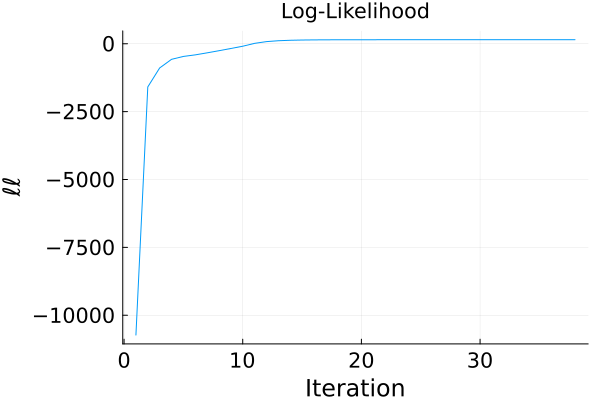

In [25]:
plot(lls, title="Log-Likelihood", xlabel="Iteration", ylabel="ℓℓ", legend=false)

## Plot the Posterior Distribution of the States


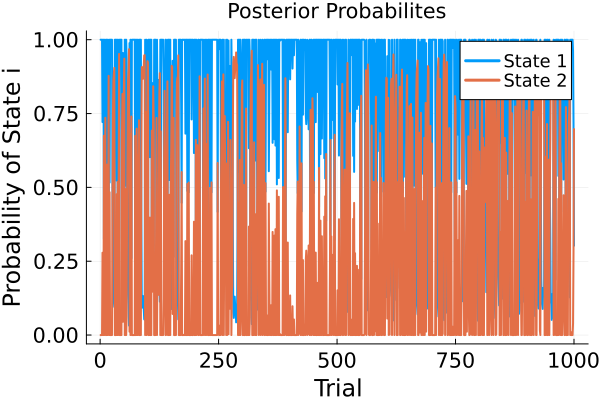

In [26]:
# get the posterior distribution of the hidden states
posterior = forward(hmm_est, all_results; seq_ends=seq_ends)
γ = posterior[1]

plot(γ[1, 1:1000], title="Posterior Probabilites", xlabel="Trial", ylabel="Probability of State i", label="State 1", linewidth=2)
plot!(γ[2, 1:1000], label="State 2", linewidth=2)

## Post-Hoc Analysis of HMM-DDM

In [27]:
fitted_models = [load(joinpath("../data/results", mouse_name * "_hmm.jld2")) for mouse_name in trial_counts.name[1:3]]

ArgumentError: ArgumentError: No file exists at given path: ../data/results\MABL6-9_hmm.jld2

In [28]:
function plot_two_state_hmm_heatmap(state1_probs::Vector{Float64}, sequence_ends::Vector{Int}; 
                                  color_scheme=:viridis, 
                                  fig_size=(900, 400),
                                  title="Probability of State 1")
    # state1_probs is a vector of length N (total time points across all sequences)
    # containing probabilities of being in State 1
    
    N = length(state1_probs)
    
    # Calculate sequence starts
    sequence_starts = [1; sequence_ends[1:end-1] .+ 1]
    n_sequences = length(sequence_ends)
    
    # Find maximum sequence length
    max_length = maximum(sequence_ends .- sequence_starts .+ 1)
    
    # Create data array for the heatmap (initialize with NaN)
    heatmap_data = fill(NaN, (n_sequences, max_length))
    
    # Fill in data for each sequence
    for seq in 1:n_sequences
        start_idx = sequence_starts[seq]
        end_idx = sequence_ends[seq]
        seq_length = end_idx - start_idx + 1
        
        # Extract probabilities for this sequence
        heatmap_data[seq, 1:seq_length] = state1_probs[start_idx:end_idx]
    end
    
    # Create the heatmap
    hm = heatmap(heatmap_data,
                c=color_scheme,
                title=title,
                xlabel="Time Step",
                ylabel="Sequence",
                yticks=(1:n_sequences, ["Seq $i" for i in 1:n_sequences]),
                clim=(0,1),
                colorbar_title="Probability",
                fillalpha=0.8,
                size=fig_size)
    
    return hm
end

plot_two_state_hmm_heatmap (generic function with 1 method)

In [29]:
function state_dependent_histogram(true_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                 simulated_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                 n_bins::Int=100)
    # Unpack the data
    true_results, true_states = true_data
    sim_results, sim_states = simulated_data
    
    # Create empty plots
    p1 = plot(title="State 1 Response Times", xlabel="RT (s)", ylabel="Density")
    p2 = plot(title="State 2 Response Times", xlabel="RT (s)", ylabel="Density")
    
    # Stratify data by state and correctness
    # State 1
    state1_true_idx = findall(x -> x == 1, true_states)
    state1_sim_idx = findall(x -> x == 1, sim_states)
    
    state1_true_correct = [r.rt for (i, r) in enumerate(true_results) if i in state1_true_idx && r.choice == 1]
    state1_true_error = [r.rt for (i, r) in enumerate(true_results) if i in state1_true_idx && r.choice == -1]
    
    state1_sim_correct = [r.rt for (i, r) in enumerate(sim_results) if i in state1_sim_idx && r.choice == 1]
    state1_sim_error = [r.rt for (i, r) in enumerate(sim_results) if i in state1_sim_idx && r.choice == -1]
    
    # State 2
    state2_true_idx = findall(x -> x == 2, true_states)
    state2_sim_idx = findall(x -> x == 2, sim_states)
    
    state2_true_correct = [r.rt for (i, r) in enumerate(true_results) if i in state2_true_idx && r.choice == 1]
    state2_true_error = [r.rt for (i, r) in enumerate(true_results) if i in state2_true_idx && r.choice == -1]
    
    state2_sim_correct = [r.rt for (i, r) in enumerate(sim_results) if i in state2_sim_idx && r.choice == 1]
    state2_sim_error = [r.rt for (i, r) in enumerate(sim_results) if i in state2_sim_idx && r.choice == -1]
    
    # Handle case where arrays might be empty
    if isempty(state1_true_correct) && isempty(state1_true_error) && 
       isempty(state1_sim_correct) && isempty(state1_sim_error) &&
       isempty(state2_true_correct) && isempty(state2_true_error) && 
       isempty(state2_sim_correct) && isempty(state2_sim_error)
        return plot(title="No data available")
    end
    
    # Find common RT range for appropriate binning
    all_rts = vcat(
        state1_true_correct, state1_true_error, state1_sim_correct, state1_sim_error,
        state2_true_correct, state2_true_error, state2_sim_correct, state2_sim_error
    )
    
    min_rt = minimum(all_rts)
    max_rt = maximum(all_rts)
    rt_range = (min_rt, max_rt)
    
    # Calculate histogram data manually
    # Create the bins
    bin_edges = range(min_rt, max_rt, length=n_bins+1)
    bin_width = (max_rt - min_rt) / n_bins
    bin_centers = range(min_rt + bin_width/2, max_rt - bin_width/2, length=n_bins)
    
    # Function to compute histogram heights
    function compute_hist_heights(data, normalize=true)
        if isempty(data)
            return zeros(n_bins)
        end
        hist = fit(Histogram, data, bin_edges)
        heights = hist.weights
        if normalize
            heights = heights ./ (sum(heights) * bin_width)
        end
        return heights
    end
    
    # Compute histogram heights for all datasets
    s1_true_correct_heights = compute_hist_heights(state1_true_correct)
    s1_true_error_heights = compute_hist_heights(state1_true_error)
    s1_sim_correct_heights = compute_hist_heights(state1_sim_correct)
    s1_sim_error_heights = compute_hist_heights(state1_sim_error)
    
    s2_true_correct_heights = compute_hist_heights(state2_true_correct)
    s2_true_error_heights = compute_hist_heights(state2_true_error)
    s2_sim_correct_heights = compute_hist_heights(state2_sim_correct)
    s2_sim_error_heights = compute_hist_heights(state2_sim_error)
    
    # Plot histograms using bar plots
    # State 1 - Correct trials (positive y-axis)
    bar!(p1, bin_centers, s1_true_correct_heights, 
        label="True Data (Correct)", alpha=0.8, color=:blue, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p1, bin_centers, s1_sim_correct_heights, 
        label="Simulated Data (Correct)", alpha=0.8, color=:lightblue, 
        bar_width=bin_width, linewidth=0)
    
    # State 1 - Error trials (negative y-axis)
    bar!(p1, bin_centers, -s1_true_error_heights, 
        label="True Data (Error)", alpha=0.8, color=:red, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p1, bin_centers, -s1_sim_error_heights, 
        label="Simulated Data (Error)", alpha=0.8, color=:pink, 
        bar_width=bin_width, linewidth=0)
    
    # State 2 - Correct trials (positive y-axis)
    bar!(p2, bin_centers, s2_true_correct_heights, 
        label="True Data (Correct)", alpha=0.8, color=:blue, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p2, bin_centers, s2_sim_correct_heights, 
        label="Simulated Data (Correct)", alpha=0.8, color=:lightblue, 
        bar_width=bin_width, linewidth=0)
    
    # State 2 - Error trials (negative y-axis)
    bar!(p2, bin_centers, -s2_true_error_heights, 
        label="True Data (Error)", alpha=0.8, color=:red, 
        bar_width=bin_width, linewidth=0)
    
    bar!(p2, bin_centers, -s2_sim_error_heights, 
        label="Simulated Data (Error)", alpha=0.8, color=:pink, 
        bar_width=bin_width, linewidth=0)
    
    # Add horizontal line at y=0
    hline!(p1, [0], color=:black, linestyle=:dash, label=nothing)
    hline!(p2, [0], color=:black, linestyle=:dash, label=nothing)
    
    # Manually set y-ticks with absolute values as labels
    # Find the maximum y value (positive or negative) to set symmetric ticks
    max_y1 = max(
        maximum(s1_true_correct_heights), 
        maximum(s1_sim_correct_heights),
        maximum(s1_true_error_heights),
        maximum(s1_sim_error_heights)
    )
    
    max_y2 = max(
        maximum(s2_true_correct_heights), 
        maximum(s2_sim_correct_heights),
        maximum(s2_true_error_heights),
        maximum(s2_sim_error_heights)
    )
    
    # Create symmetric tick positions
    y_ticks1 = collect(range(-max_y1, max_y1, length=7))
    y_ticks2 = collect(range(-max_y2, max_y2, length=7))

    # Format tick labels with restricted significant figures (2 decimal places)
    format_tick(y) = @sprintf("%.2f", abs(y))

    # Set ticks with formatted absolute values as labels
    yticks!(p1, y_ticks1, [format_tick(y) for y in y_ticks1])
    yticks!(p2, y_ticks2, [format_tick(y) for y in y_ticks2])
    
    # Add annotations 
    max_correct_height1 = maximum(s1_true_correct_heights)
    max_error_height1 = maximum(s1_true_error_heights)
    
    max_correct_height2 = maximum(s2_true_correct_heights)
    max_error_height2 = maximum(s2_true_error_heights)
    
    # Create combined plot
    combined_plot = plot(p1, p2, layout=(2,1), size=(1100, 800), legend=:topright)
    
    return combined_plot
end

state_dependent_histogram (generic function with 2 methods)